# Sequence

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据

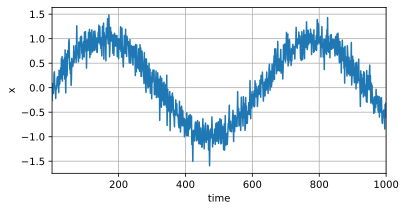

In [2]:
# 定义时间序列的长度
T = 1000
# 生成时间序列
time = torch.arange(1, T + 1, dtype=torch.float32)
# 生成带噪声的正弦波形
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# 绘制时间序列图像
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## 参数定义

In [3]:
# 定义时间步数
tau = 4
# 初始化特征矩阵
features = torch.zeros((T - tau, tau))
# 通过循环，将时间序列 x 中的数据按照时间步数 tau 分割成多个样本，并将这些样本作为特征矩阵的列
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
# 初始化标签矩阵
labels = x[tau:].reshape((-1, 1))

# 定义批量大小和训练集大小
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
# 使用 d2l 库中的 load_array 函数将特征矩阵 features 和标签矩阵 labels 转换成迭代器 train_iter，用于迭代训练集
train_iter = d2l.load_array(
    (
        features[:n_train], 
        labels[:n_train]
    ),
    batch_size, is_train=True
)

## 模型定义

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

## 训练

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.061189
epoch 2, loss: 0.053364
epoch 3, loss: 0.052569
epoch 4, loss: 0.054722
epoch 5, loss: 0.054494
epoch 6, loss: 0.049534
epoch 7, loss: 0.050408
epoch 8, loss: 0.048656
epoch 9, loss: 0.048204
epoch 10, loss: 0.048065


## 测试

### 单步预测

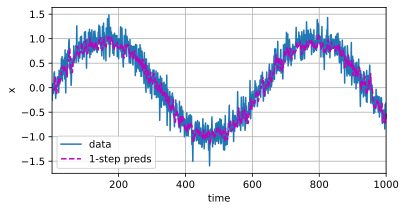

In [6]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 
    'time', 'x', 
    legend=['data', '1-step preds'], 
    xlim=[1, 1000],
    figsize=(6, 3)
)

### 多步预测

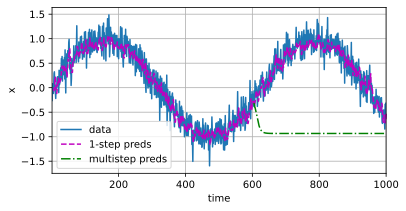

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot(
    [
        time, 
        time[tau:], 
        time[n_train + tau:]
    ],
    [
        x.detach().numpy(), 
        onestep_preds.detach().numpy(),
        multistep_preds[n_train + tau:].detach().numpy()
    ], 
    'time', 'x', 
    legend=[
        'data', 
        '1-step preds', 
        'multistep preds'
    ],
    xlim=[1, 1000], 
    figsize=(6, 3)
)

### k-step预测

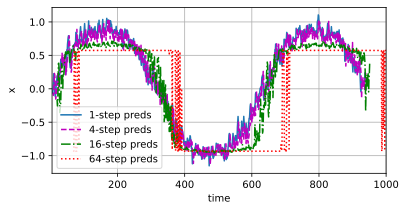

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot(
    [time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
    'time', 'x',
    legend=[f'{i}-step preds' for i in steps], 
    xlim=[5, 1000],
    figsize=(6, 3)
)